In [5]:
from google.colab import drive                                                    # Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd                                                               # Importing all the required Libraries
import numpy as np
np.random.seed(1)

import matplotlib.pyplot as plt
import seaborn as sns
                                
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LogisticRegression, Perceptron

pd.set_option("display.max_rows", None, "display.max_columns", None)


!pip install colorama
from colorama import Fore


import warnings                                                                   # Removing all those annoying Warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [7]:
credit_card_df = pd.read_csv('/content/drive/MyDrive/german_credit_data (2).csv') # Reading the CSV file

In [8]:
credit_card_df.head()                                                             # Looking at the Dataset

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Class
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,2
2,49,male,1,own,little,NaN,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,2


In [9]:
credit_card_df.info()                                                              # Checking for Data types and all the number of missing Values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Class             1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


Their are a few nulls in Column Saving accounts and Checking Accounts, dataset contains 5 numerical columns and 5 catagorical columns, well handle these catagorical columns and Missing Values as we procede

In [10]:
credit_card_df.describe()                                                         # Getting Statistical Inferences from the Data

,Age,Job,Credit amount,Duration,Class
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000,1.300000
std,11.375469,0.653614,2822.736876,12.058814,0.458487
min,19.000000,0.000000,250.000000,4.000000,1.000000
25%,27.000000,2.000000,1365.500000,12.000000,1.000000
50%,33.000000,2.000000,2319.500000,18.000000,1.000000
75%,42.000000,2.000000,3972.250000,24.000000,2.000000
max,75.000000,3.000000,18424.000000,72.000000,2.000000


In [11]:
column_list=credit_card_df.columns
count_dataset=pd.DataFrame()
distinct_features=[]                                                                                          #Empty list to know the number of distict features,sum of all these values, and sum of values top 10 comprises
for i in column_list:                                                                                       
  count_dataset[i]= pd.Series(credit_card_df[i].value_counts().sort_values(ascending=False).head(10).index)      
  count_dataset[f'{i}_count']=pd.Series(credit_card_df[i].value_counts().sort_values(ascending=False).head(10).values).astype('int')   
  distinct_features.append((len(credit_card_df[i].value_counts().index),credit_card_df[i].value_counts().sum(),credit_card_df[i].value_counts().sort_values(ascending=False).head(10).sum())) 
final_tally=list(zip(column_list,distinct_features))                                                          #Zipping with column_list
col_ref={}  
for i in column_list:
  if i in ['Class']:                                                                                          #colur red shows the Dependent Variable('default payment next month')
    col_ref[i]='background-color: red'  
  else:
    col_ref[i]='background-color: blue'                                                                       #colur blue shows the features 
  temp=f'{i}_count'
  col_ref[temp]='background-color: green'                                                                     #colur green shows the count
def Nan_as_black(val):
  if str(val)=='nan':
    color = 'black'
    return 'color: %s' % color
count_dataset=count_dataset.style.apply(lambda x: pd.DataFrame(col_ref, index=count_dataset.index, columns=count_dataset.columns).fillna(''), axis=None).highlight_null('black').applymap(Nan_as_black)
count_dataset

,Age,Age_count,Sex,Sex_count,Job,Job_count,Housing,Housing_count,Saving accounts,Saving accounts_count,Checking account,Checking account_count,Credit amount,Credit amount_count,Duration,Duration_count,Purpose,Purpose_count,Class,Class_count
0,27,51,male,690.000000,2.000000,630.000000,own,713.000000,little,603.000000,little,274.000000,1478,3,24,184,car,337.000000,1.000000,700.000000
1,26,50,female,310.000000,1.000000,200.000000,rent,179.000000,moderate,103.000000,moderate,269.000000,1258,3,12,179,radio/TV,280.000000,2.000000,300.000000
2,23,48,nan,nan,3.000000,148.000000,free,108.000000,quite rich,63.000000,rich,63.000000,1275,3,18,113,furniture/equipment,181.000000,nan,nan
3,24,44,nan,nan,0.000000,22.000000,nan,nan,rich,48.000000,nan,nan,1393,3,36,83,business,97.000000,nan,nan
4,28,43,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1262,3,6,75,education,59.000000,nan,nan
5,25,41,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1424,2,15,64,repairs,22.000000,nan,nan
6,30,40,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1935,2,9,49,domestic appliances,12.000000,nan,nan
7,35,40,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1386,2,48,48,vacation/others,12.000000,nan,nan
8,36,39,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,2406,2,30,40,nan,nan,nan,nan
9,31,38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,1236,2,21,30,nan,nan,nan,nan


In [12]:
final_tally

[('Age', (53, 1000, 434)),
 ('Sex', (2, 1000, 1000)),
 ('Job', (4, 1000, 1000)),
 ('Housing', (3, 1000, 1000)),
 ('Saving accounts', (4, 817, 817)),
 ('Checking account', (3, 606, 606)),
 ('Credit amount', (921, 1000, 25)),
 ('Duration', (33, 1000, 865)),
 ('Purpose', (8, 1000, 1000)),
 ('Class', (2, 1000, 1000))]

In [13]:
'''
as we can see from above their are mainly two sex i.e. mail and Female thus
we will convert this categorical coloumn into numerical by giving value for 
male as 0 and female as 1
'''
credit_card_df['Sex']=credit_card_df['Sex'].apply(lambda x : np.where(x=='male', 1, 0))  # Assigning 1 to male and 0 to female
'''
for housing column assigning own as 1 ,free as 0, rent as 2.
'''
def num_for_housing(x):
  '''
  This function takes str as input, which can be either own , free and rest
  It output a numerical value for each of them
  '''
  if str(x)=='own':
    return 1
  elif str(x)=='free':
    return 0
  elif str(x) =='rent':
    return 2

credit_card_df['Housing']=credit_card_df['Housing'].apply(lambda x : num_for_housing(x) )  # Assigning 0 to Free, 1 to Own and 2 to Rent

'''
for savings account
Saving accounts :  [nan 'little' 'quite rich' 'rich' 'moderate']
Saving accounts :  [4 0 2 3 1]
'''
def num_for_savings_ac(x):
  '''
  This function takes nan or str as input, which can be either be little , quite rich 
  rich and moderate.
  It output a numerical value for each of them as 4,0, 2,3,1 respectively
  '''
  if str(x)=='little':
    return 0
  elif str(x)=='quite rich':
    return 2
  elif str(x) =='rich':
    return 3
  elif str(x)== 'moderate':
    return 1
  else:
    return 4

credit_card_df['Saving accounts']=credit_card_df['Saving accounts'].apply(lambda x : num_for_savings_ac(x) )  # Assigning num variable 

'''
for checking account
Checking account :  ['little' 'moderate' nan 'rich']
Checking account :  [0 1 3 2]
'''

def num_for_checking_ac(x):
  '''
  This function takes nan or str as input, which can be either be little 
  moderate and rich.
  It output a numerical value for each of them as 3,0,1,2 respectively
  '''
  if str(x)=='little':
    return 0
  elif str(x) =='rich':
    return 2
  elif str(x)== 'moderate':
    return 1
  else:
    return 3

credit_card_df['Checking account']=credit_card_df['Checking account'].apply(lambda x : num_for_checking_ac(x) )  # Assigning num variable 

'''
For purpose
Purpose :  ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
            'domestic appliances' 'repairs' 'vacation/others']
Purpose :  [5 3 4 1 0 2 6 7]
'''
def num_for_pupose(x):
  '''
  This function takes nan or str as input and give a correspoding num outpu 
  '''
  if str(x)=='radio/TV':
    return 5
  elif str(x) =='education':
    return 3
  elif str(x)== 'furniture/equipment':
    return 4
  elif str(x) =='car':
    return 1
  elif str(x)== 'business':
    return 0
  elif str(x) =='domestic appliances':
    return 2
  elif str(x)== 'repairs':
    return 6
  elif str(x)== 'vacation/others':
    return 7

credit_card_df['Purpose']=credit_card_df['Purpose'].apply(lambda x : num_for_pupose(x) )  # Assigning num variable 

'''
Making our classes 0 and 1 instead of 1 and 2
'''
credit_card_df['Class']=credit_card_df['Class'].apply(lambda x : x-1 )

In [14]:
credit_card_df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Class
0,67,1,2,1,4,0,1169,6,5,0
1,22,0,2,1,0,1,5951,48,5,1
2,49,1,1,1,0,3,2096,12,3,0
3,45,1,2,0,0,0,7882,42,4,0
4,53,1,2,0,0,0,4870,24,1,1


In [15]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Age               1000 non-null   int64
 1   Sex               1000 non-null   int64
 2   Job               1000 non-null   int64
 3   Housing           1000 non-null   int64
 4   Saving accounts   1000 non-null   int64
 5   Checking account  1000 non-null   int64
 6   Credit amount     1000 non-null   int64
 7   Duration          1000 non-null   int64
 8   Purpose           1000 non-null   int64
 9   Class             1000 non-null   int64
dtypes: int64(10)
memory usage: 78.2 KB


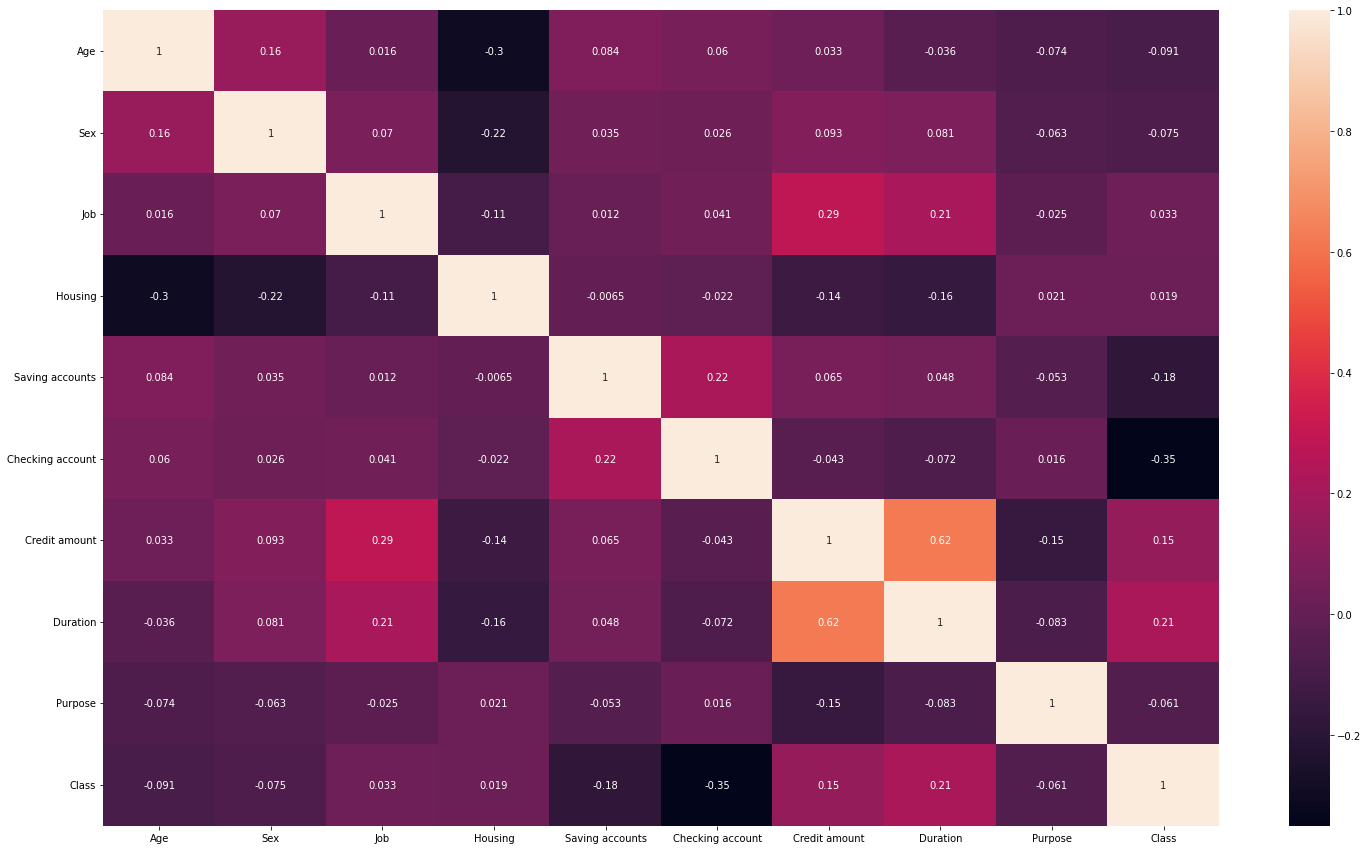

In [16]:
corr = credit_card_df.corr()                                                                  # Plotting co-relation chart
plt.figure(figsize=(25,15))
sns.heatmap(corr, annot=True)
plt.show()    

In [17]:
df_class1 = credit_card_df[credit_card_df['Class']==1]
df_class1.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Class
1,22,0,2,1,0,1,5951,48,5,1
4,53,1,2,0,0,0,4870,24,1,1
9,28,1,3,1,0,1,5234,30,1,1
10,25,0,2,2,0,1,1295,12,1,1
11,24,0,2,2,0,0,4308,48,0,1


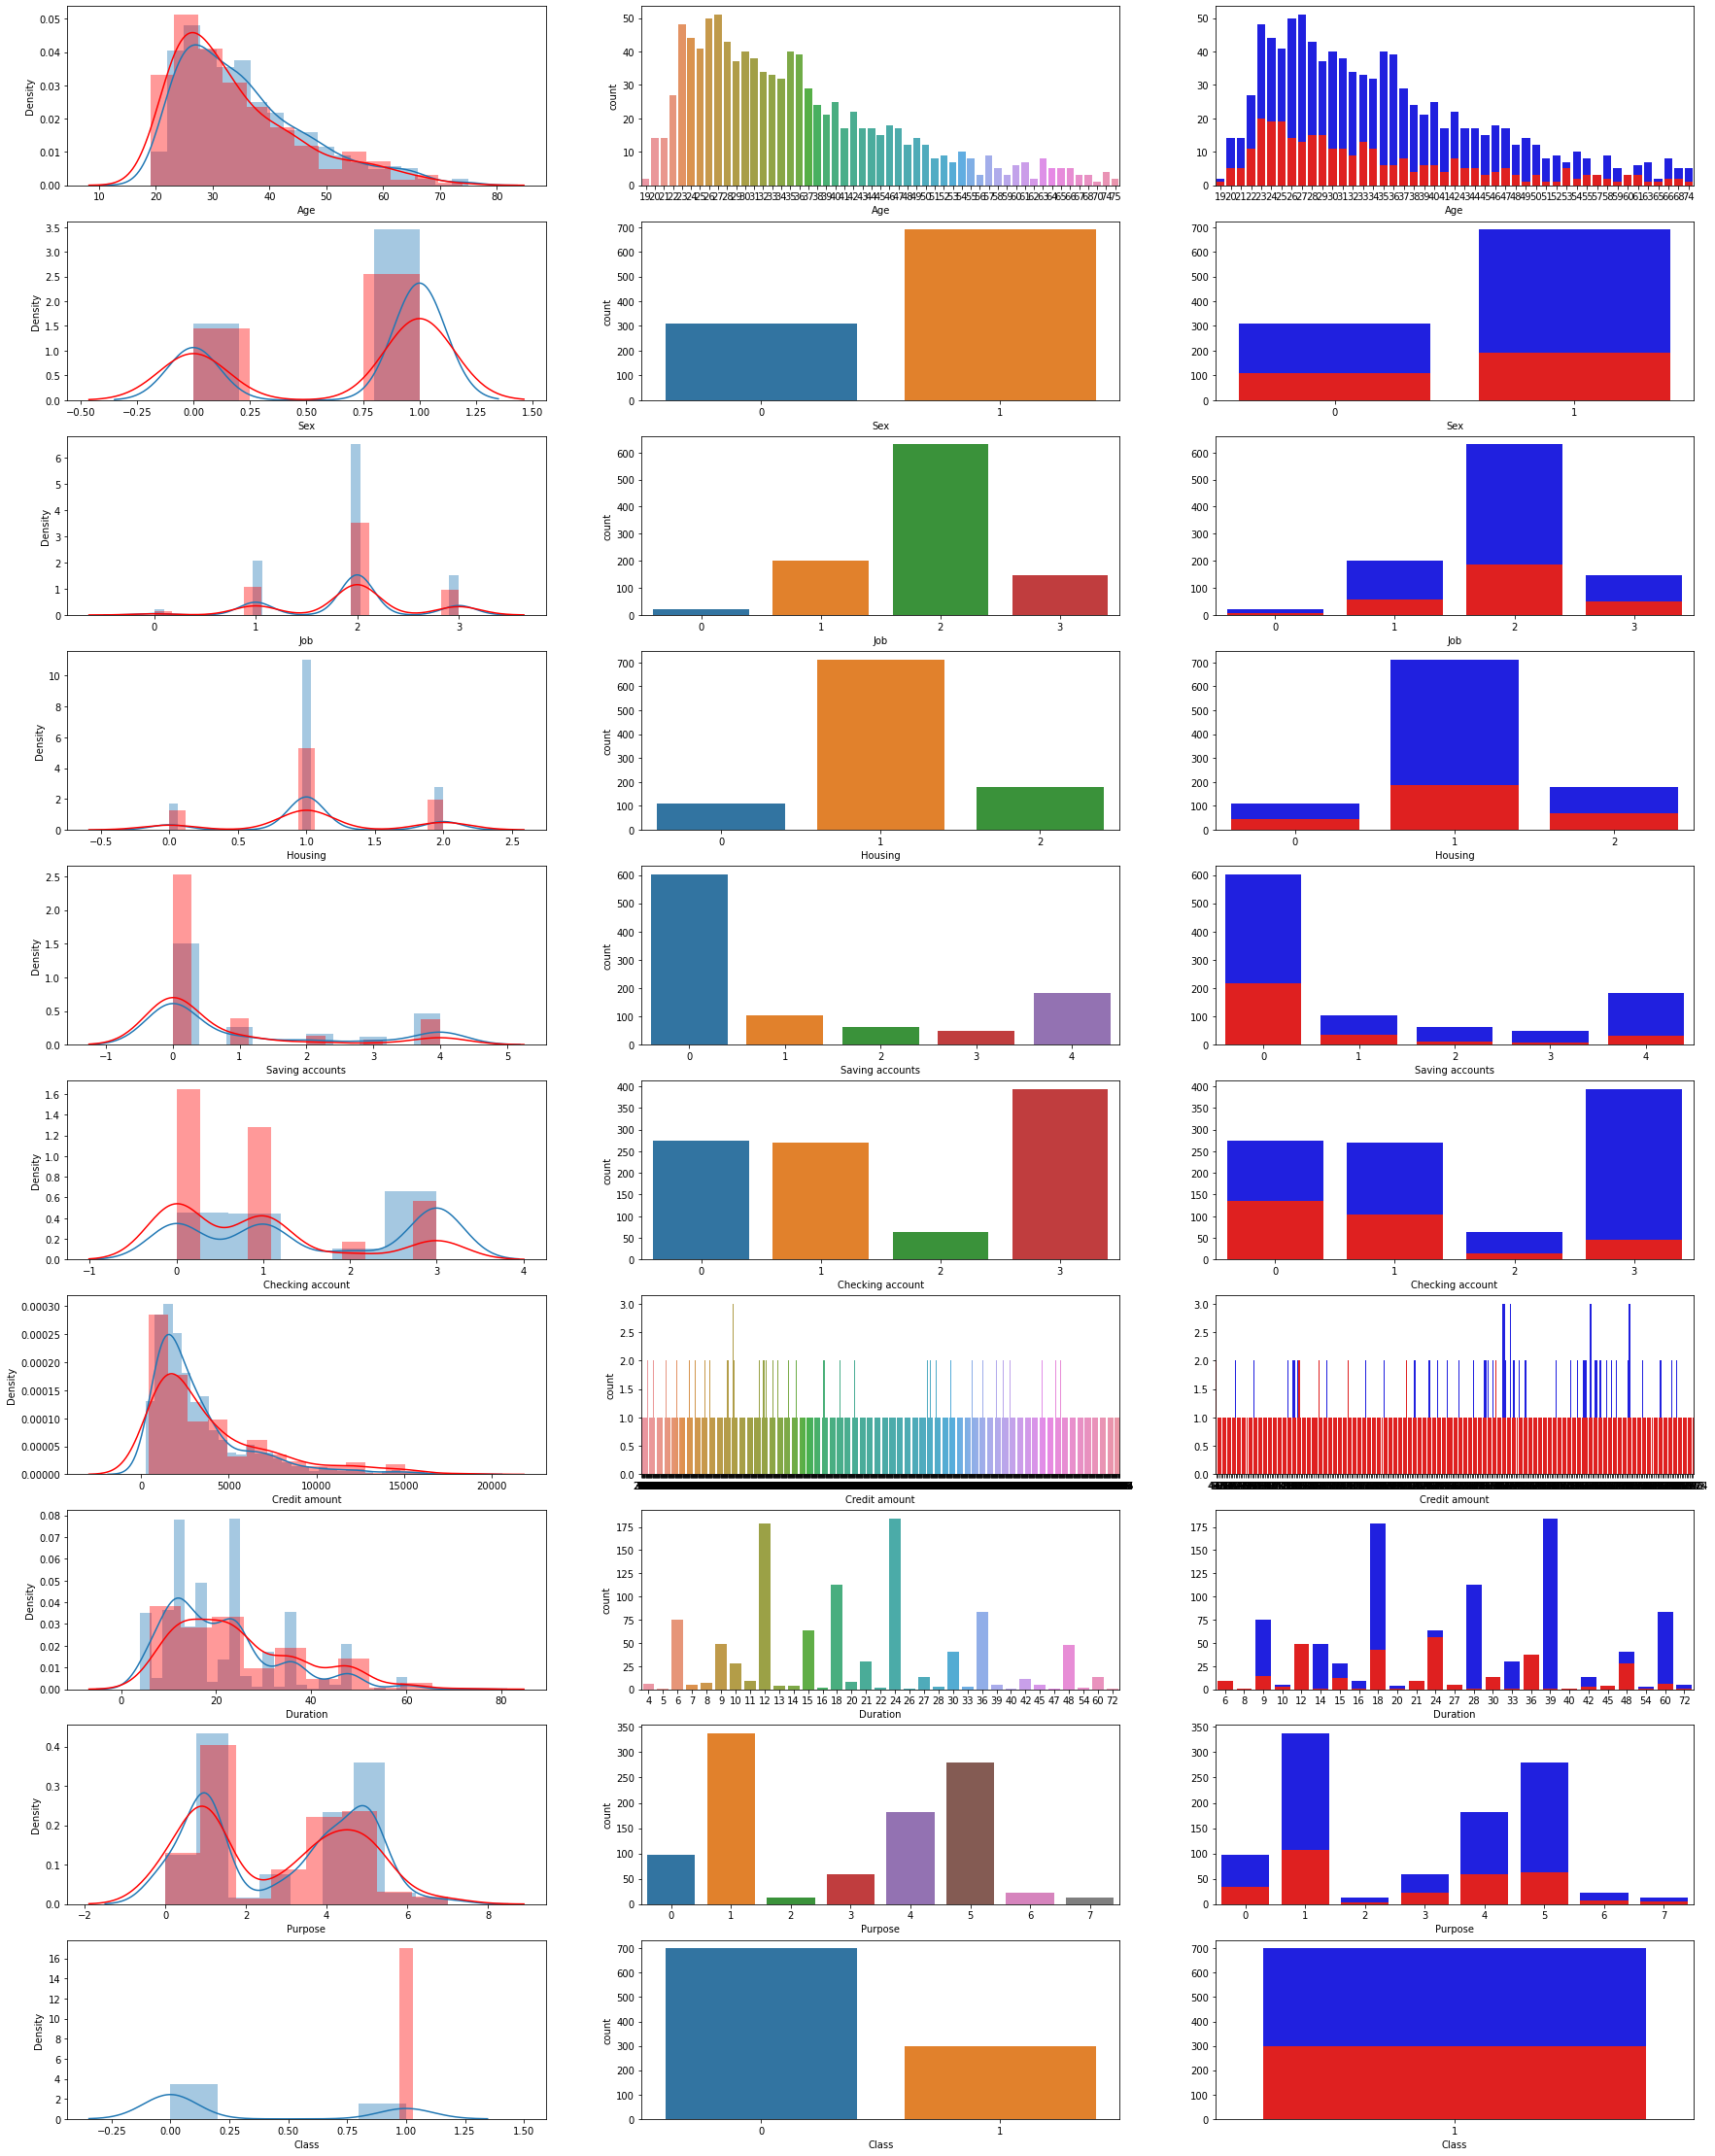

In [18]:
columns = credit_card_df.columns
fig, axs = plt.subplots(len(columns),3,figsize=(30,40))
count=0
for i in columns:
    sns.distplot(credit_card_df[i],ax=axs[count,0])                                         #shows the overall distribution 
    sns.distplot(df_class1[i],ax=axs[count,0],color='r')                       #shows the distribution of defaulters
    count+=1
count=0
for i in columns:
    sns.countplot(credit_card_df[i],ax=axs[count,1])
    count+=1
counter=0
for i in columns:
  temp=credit_card_df.groupby(i)['Class'].count()
  temp2=df_class1.groupby(i)['Class'].count() 
  sns.barplot(temp.index,temp.values,ax=axs[counter,2],color='b')               #Blue Colour represents Data for both Defaulters and non-Defaulters
  sns.barplot(temp2.index,temp2.values,color='r',ax=axs[counter,2])             ##Red color represents the Defaulters
  counter+=1

In [19]:
'''
As we can see that our model is suffering from the problem of class imbalance
we will be creating synthetic data using SMOTE 
'''

X = credit_card_df.drop(["Class"],axis =1 )                                      # Making Final Datasets
y = credit_card_df["Class"]

# oversample = SMOTE()                                                             #using oversampling technique to create synthetic data and deal with class inbalance
# X, y = oversample.fit_resample(X, y)

In [20]:
scaler=MinMaxScaler(feature_range=(0,1))
X=scaler.fit_transform(X)

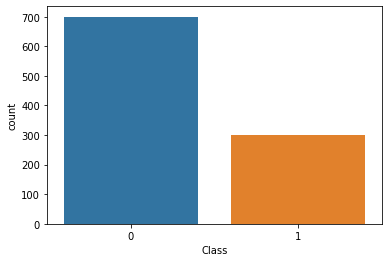

In [21]:
sns.countplot(y)                                                                 # Both the classes are Balanced now

In [22]:
''' Creating Training and Testing Data Set '''
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size =0.2,
                                                 random_state=0)                 # train test split

print(f'Shape of X_train is {X_train.shape} and y_train is {y_train.shape}')
print(f'Shape of X_test is {X_test.shape} and y_test is {y_test.shape}')

Shape of X_train is (800, 9) and y_train is (800,)
Shape of X_test is (200, 9) and y_test is (200,)


# Perceptron model

In [175]:
from io import BufferedIOBase
'''
Coding Perceptron Model from Scratch
'''

class Simple_Perceptron:                                                         # Naming the class as simple perceptron

  def __init__(self, learning_rate=0.1, epochs=100, weights=None, bias=None, thresh=0):              # Initializing the class using constructor
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.weights = weights                                                       # If Pre- trained weights are not provided we will create a zero matrix 
    self.bias =bias     
    self.thresh=thresh                                                           # will start with bias as 0 if not provided
  

  def fit(self, X_train, y_train, return_bias_and_weight= False):
    
    if (self.weights) is not None :
      pass
    else :
      self.weights= np.zeros(X_train.shape[1])                                   # this is give out a zero matrix of shape 1 X columns in X_train
   
    if (self.bias) is not None:
      pass
    else:
      self.bias=0

    loss_list=[]
    for epoch in range(self.epochs):                                             # our model will be trained till the number of epoch we have set is reached
      local_loss=[]
      for i in range(X_train.shape[0]):
        
 
        y_pred= self.threshold(np.dot(self.weights, X_train[i]) + self.bias)     # y_pred is qual to dot product on X_train and weights plus bais

        self.weights =self.weights +self.learning_rate*(y_train[i] - y_pred)* X_train[i]    # X_train is a vector which would transform scaler into vectors thus facilitates in addition 

        self.bias = self.bias + self.learning_rate* (y_train[i] - y_pred)   
        local_loss.append(np.mean([0.0, 1 - y_pred*y_train[i]]))                 # Hinge Loss
        
      loss_list.append(np.mean((local_loss)))
    print(Fore.RED +f'Model has been Trained {Fore.BLUE} \n\nWeights : {self.weights} {Fore.GREEN} \n\nBias : {self.bias}')

    if return_bias_and_weight:
      return self.bias, self.weights, loss_list

  def threshold(self, val):                                                      # activation function is needed to add threshold
    if val >=self.thresh:
    
      return 1

    else:
      return 0

  def predict(self, X_test):

    y_pred=[]
    y_pred2=[]
    for i in range(X_test.shape[0]):
      y_pred.append(self.threshold(np.dot(self.weights, X_test[i])+ self.bias))
      y_pred2.append(np.dot(self.weights, X_test[i])+ self.bias)
    print(np.mean(np.array(y_pred2)))
    return np.array(y_pred)
      

----------------------------------------------------------------------------------------------------
Model has been Trained  

Weights : [-0.12142857  0.1         0.06666667  0.05       -0.275      -0.26666667
 -0.00818752  0.29852941  0.1       ]  

Bias : -2.7755575615628914e-17
-0.0015023026871011302
0.0022103679171522747
Accuracy of model at threshold 0.0 is 0.64


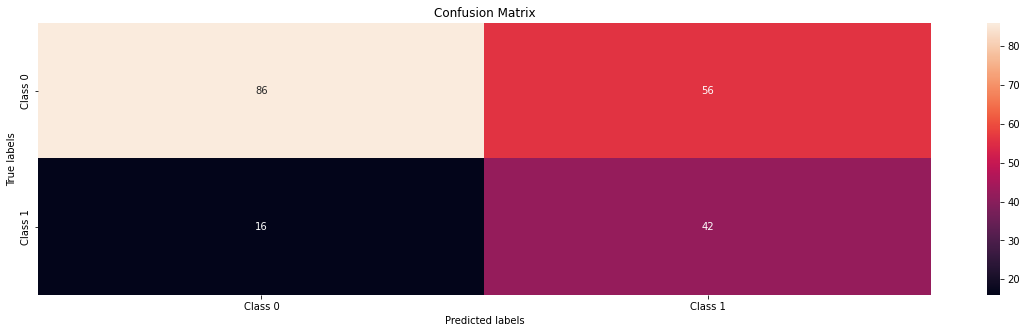

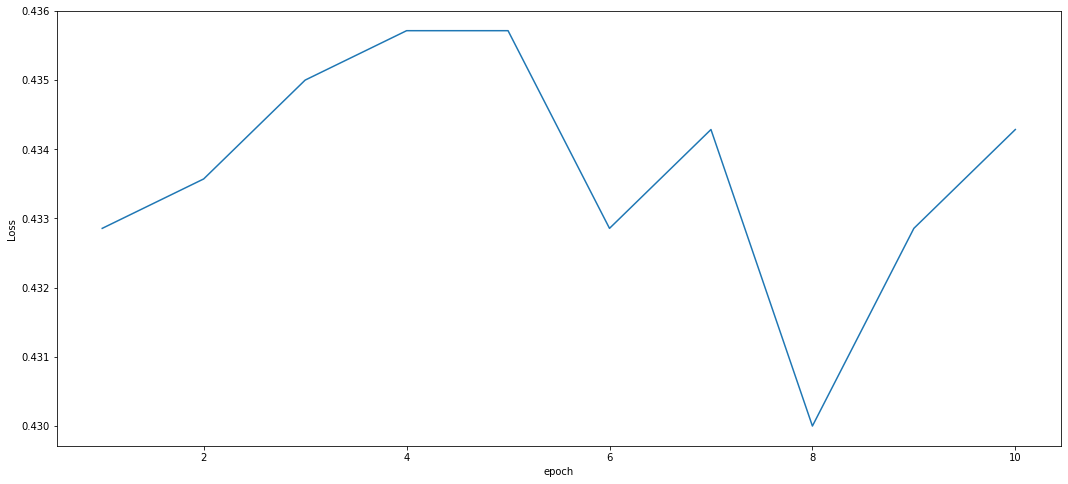

              precision    recall  f1-score   support

           0       0.84      0.61      0.70       142
           1       0.43      0.72      0.54        58

    accuracy                           0.64       200
   macro avg       0.64      0.66      0.62       200
weighted avg       0.72      0.64      0.66       200



In [200]:
threshold_list=[0.0]
for i in threshold_list:
  print('-'*100)
  model =Simple_Perceptron(learning_rate=0.1, epochs=10, thresh=i)
  bias,weights,loss_list=model.fit(X_train, y_train.values, True)
  y_pred =model.predict(X_test)
  y_pred_train=model.predict(X_train)
  print(f'Accuracy of model at threshold {i} is {accuracy_score(y_test,y_pred)}')

  labels = ['Class 0', 'Class 1']
  cm_test = confusion_matrix(y_test, y_pred)
  fig, ax= plt.subplots(figsize=(20,5))
  sns.heatmap(cm_test, annot=True, ax = ax) 
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  plt.show()

  print('\n\n')
  plt.figure(figsize=(18,8))
  df= pd.DataFrame()
  df['epoch']=range(1,len(loss_list)+1)
  df['Loss']=loss_list
  sns.lineplot(data=df, y='Loss', x='epoch')
  plt.show()

  print(classification_report(y_test, y_pred))

* Looking at the loss plot we can infer that we should stop the model training after 8 epochs because after that the model is overfitting the dataset, which means that model is learning the noise thus to avoide overfitting it is advisable to stop overtraining


In [201]:
'''
Creating Validation Set, to avoid overfitting 
'''
X_train2,X_val,y_train2,y_val = train_test_split(X,y, test_size =0.3,
                                                 random_state=0)     


In [202]:
updated_df= pd.DataFrame(X_train)
updated_df['Class']=y_pred_train

In [203]:
updated_df.head()

,0,1,2,3,4,5,6,7,8,Class
0,0.357143,1.0,1.000000,0.5,0.00,0.333333,0.643117,0.294118,1.000000,1
1,0.321429,1.0,0.666667,0.0,0.00,1.000000,0.086332,0.470588,0.428571,1
2,0.446429,1.0,0.666667,0.5,0.00,0.000000,0.067569,0.161765,0.571429,1
3,0.428571,0.0,0.333333,0.5,0.75,1.000000,0.069660,0.294118,0.714286,0
4,0.107143,1.0,0.666667,0.5,0.00,0.000000,0.103775,0.073529,0.571429,1


In [204]:
updated_df['Class'].value_counts()

1    358
0    342
Name: Class, dtype: int64

In [205]:
df_class_1= updated_df[updated_df['Class']==1]                                  # Only values as 1
df_class_0= updated_df[updated_df['Class']==0]                                  # Only values as 0

In [206]:
X_class_1= np.array(df_class_1.drop('Class', axis=1) )
y_class_1= np.array(df_class_1['Class'])

X_class_0= np.array(df_class_0.drop('Class', axis=1))
y_class_0= np.array(df_class_0['Class'])


Model has been Trained  

Weights : [-0.12142857  0.1         0.06666667  0.05       -0.275      -0.26666667
 -0.00818752  0.29852941  0.1       ]  

Bias : -2.7755575615628914e-17
-0.005085946818837614
Accuracy of model at threshold 0.0 is 0.6466666666666666


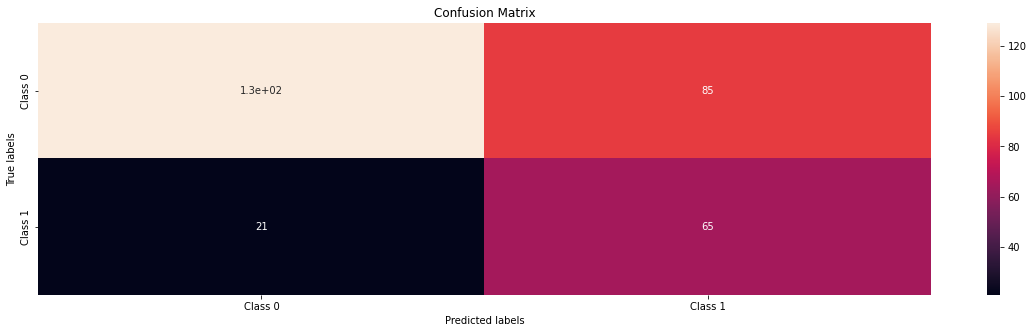




              precision    recall  f1-score   support

           0       0.86      0.60      0.71       214
           1       0.43      0.76      0.55        86

    accuracy                           0.65       300
   macro avg       0.65      0.68      0.63       300
weighted avg       0.74      0.65      0.66       300



In [207]:
model =Simple_Perceptron(learning_rate=0.1, epochs=4, thresh=0, weights=weights, bias=bias)
final_bias,final_weights,loss_list= model.fit(X_class_1, y_class_1, True)

y_pred =model.predict(X_val)

print(f'Accuracy of model at threshold {i} is {accuracy_score(y_val,y_pred)}')

labels = ['Class 0', 'Class 1']
cm_test = confusion_matrix(y_val, y_pred)
fig, ax= plt.subplots(figsize=(20,5))
sns.heatmap(cm_test, annot=True, ax = ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print('\n\n')

print(classification_report(y_val, y_pred))

Model has been Trained  

Weights : [-0.12142857  0.1         0.06666667  0.05       -0.275      -0.26666667
 -0.00818752  0.29852941  0.1       ]  

Bias : -2.7755575615628914e-17
-0.005085946818837614
Accuracy of model at threshold 0.0 is 0.6466666666666666


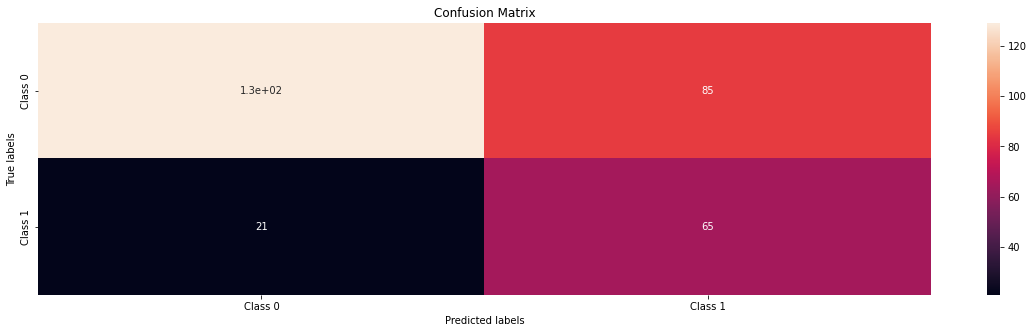




              precision    recall  f1-score   support

           0       0.86      0.60      0.71       214
           1       0.43      0.76      0.55        86

    accuracy                           0.65       300
   macro avg       0.65      0.68      0.63       300
weighted avg       0.74      0.65      0.66       300



In [211]:
model =Simple_Perceptron(learning_rate=1e-1, epochs=20, thresh=0, weights=final_weights, bias=final_bias)
bias_2,weights_2,loss_list= model.fit(X_class_0, y_class_0, True)
y_pred =model.predict(X_val)

print(f'Accuracy of model at threshold {i} is {accuracy_score(y_val,y_pred)}')

labels = ['Class 0', 'Class 1']
cm_test = confusion_matrix(y_val, y_pred)
fig, ax= plt.subplots(figsize=(20,5))
sns.heatmap(cm_test, annot=True, ax = ax) 
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print('\n\n')

print(classification_report(y_val, y_pred))